# ATAC-seq - Differential accessibility analysis of treated time points compared to untreated control
- goal: DARs over time and treatment
- input: filtered raw counts
- output: QC plots (correlation heatmap, PCA), DEA results & plots

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries
library(limma)
library(ggplot2, quietly=T)
library(data.table, quietly=T)
library(pheatmap, quietly=T)
options(stringsAsFactors=F)

In [3]:
#### utility functions

source("./utils_Enrichr.R")

# Make a matrix out of a data.table
toMT <- function(dt, row, col, val){
  retDT <- dcast.data.table(dt, get(row) ~ get(col), value.var=val)
  retMT <- as.matrix(retDT[,-"row"])
  row.names(retMT) <- retDT$row
  return(retMT)
}

# Remove plots from device. Useful for pheatmap (and others?)
cleanDev <- function(n=2){sapply(1:n, function(i){try({dev.off()}, silent=TRUE)}); return(TRUE)}

# Write tsv table
write.tsv <- function(...){
  write.table(..., sep="\t", row.names=FALSE, quote=FALSE);
}

# Rotate x-axis in ggplot
xRot <- function(){theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))}

Loading required package: enrichR

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!



In [4]:
# configs
data_path <- file.path('results','ATAC','all')
results_path <- file.path('results','ATAC','all','DEA')

In [5]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE)

# Load data

In [6]:
# load annotations
annot <- read.csv(file=file.path(data_path,'all_annotation.csv'), row.names=1)
dim(annot)
head(annot)

[1] 78 29

,library,timepoint.after.thawing,cell_line,Treatment,Treatment_time,mouse_pool,sex,bio.replicate,organism,experiment_id,⋯,Treatment.Redundancy,X..Dups,X..Aligned,X..Duplication,X....Q30,Mb.Q30.bases,GC.content,X..PF,X..Adapter,pass_qc
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
PT76_R1_C_albicans_2h,ATAC-seq,d010,BMDM,C_albicans,2h,PT62_c,female,R1,mouse,PT76,⋯,0.06,0.19,0.99,0.14,0.97,609.5,0.51,1,0.10,1
PT76_R1_C_albicans_4h,ATAC-seq,d010,BMDM,C_albicans,4h,PT62_c,female,R1,mouse,PT76,⋯,0.06,0.19,0.99,0.15,0.97,748.6,0.50,1,0.12,1
PT76_R1_C_albicans_6h,ATAC-seq,d010,BMDM,C_albicans,6h,PT62_c,female,R1,mouse,PT76,⋯,0.08,0.22,0.99,0.17,0.96,675.5,0.51,1,0.10,1
PT76_R1_C_albicans_8h,ATAC-seq,d010,BMDM,C_albicans,8h,PT62_c,female,R1,mouse,PT76,⋯,0.06,0.19,0.99,0.14,0.97,733.7,0.50,1,0.11,1
PT76_R1_untreated_0h,ATAC-seq,d010,BMDM,untreated,0h,PT62_c,female,R1,mouse,PT76,⋯,0.06,0.18,0.99,0.14,0.97,769.1,0.50,1,0.13,1
PT76_R1_IFN_beta_2h,ATAC-seq,d010,BMDM,IFN_beta,2h,PT62_c,female,R1,mouse,PT76,⋯,0.06,0.20,0.99,0.16,0.97,749.0,0.50,1,0.12,1


In [7]:
# rename columns
names(annot)[names(annot) == 'Treatment'] <- 'treatment'
names(annot)[names(annot) == 'Treatment_time'] <- 'time'
names(annot)[names(annot) == 'experiment_id'] <- 'experiment'
annot$sample_name <- rownames(annot)

In [8]:
# load data
data <- read.csv(file=file.path(data_path,'all_filtered.csv'), row.names=1)
dim(data)
head(data)

[1] 136735     78

,PT76_R1_C_albicans_2h,PT76_R1_C_albicans_4h,PT76_R1_C_albicans_6h,PT76_R1_C_albicans_8h,PT76_R1_untreated_0h,PT76_R1_IFN_beta_2h,PT76_R1_IFN_beta_4h,PT76_R1_IFN_beta_6h,PT76_R1_IFN_beta_8h,PT76_R1_IFN_gamma_2h,⋯,PT82_R2_IFN_gamma_24h,PT82_R2_IFN_gamma_8h,PT82_R2_LCMV_Cl13_24h,PT82_R2_LCMV_Cl13_8h,PT82_R2_LO28_24h,PT82_R2_LO28_8h,PT82_R2_LPS_24h,PT82_R2_LPS_8h,PT82_R2_untreated_24h,PT82_R2_untreated_8h
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CONS00000000005,47,55,65,44,60,21,19,37,43,14,⋯,50,40,229,120,22,115,114,97,122,96
CONS00000000006,8,8,13,8,6,8,4,4,7,10,⋯,25,22,41,24,6,15,11,15,24,7
CONS00000000011,8,4,3,9,9,11,10,2,5,13,⋯,8,21,7,18,18,11,4,19,18,21
CONS00000000013,3,8,8,3,3,4,2,0,4,3,⋯,2,5,15,1,6,19,7,25,1,6
CONS00000000017,3,3,2,5,6,4,4,9,8,5,⋯,6,9,19,8,6,9,7,12,7,14
CONS00000000020,2,4,6,3,9,3,5,4,5,8,⋯,8,9,10,14,3,8,5,9,10,7


In [9]:
# load region annotation
annot_regions <- read.csv(file=file.path(data_path,'consensus_regions_annotation.csv'), row.names=1)
annot_regions <- annot_regions[rownames(data),]
dim(annot_regions)
head(annot_regions)

[1] 136735     25

,gencode_chr,gencode_start,gencode_end,gencode_length,gencode_feat_anchor,gencode_distance,gencode_location,gencode_feat_type,gencode_gene_id,gencode_gene_name,⋯,homer_Entrez.ID,homer_Nearest.Unigene,homer_Nearest.Refseq,homer_Nearest.Ensembl,homer_Gene.Name,homer_Gene.Alias,homer_Gene.Description,homer_Gene.Type,regulatoryBuild_reg_feature,regulatoryBuild_reg_feature_id
,<chr>,<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CONS00000000005,chr1,4414052,4415256,1204,start,5413,Upstream,gene:protein_coding,ENSMUSG00000025900.13,Rp1,⋯,19888,Mm.294263,NM_011283,ENSMUSG00000025900,Rp1,Dcdc3|Gm38717|Orp1|Rp1h|mG145,retinitis pigmentosa 1 (human),protein-coding,reg_NONE,
CONS00000000006,chr1,4416568,4417221,653,start,7653,Upstream,gene:protein_coding,ENSMUSG00000025900.13,Rp1,⋯,19888,Mm.294263,NM_011283,ENSMUSG00000025900,Rp1,Dcdc3|Gm38717|Orp1|Rp1h|mG145,retinitis pigmentosa 1 (human),protein-coding,regulatory_region,ENSMUSR00000293483
CONS00000000011,chr1,4491871,4492835,964,end,1423,PeakInsideFeature,gene:protein_coding,ENSMUSG00000025902.13,Sox17,⋯,20671,Mm.279103,NM_011441,ENSMUSG00000025902,Sox17,-,SRY (sex determining region Y)-box 17,protein-coding,regulatory_region,ENSMUSR00000293490
CONS00000000013,chr1,4622075,4622934,859,start,125150,Upstream,gene:protein_coding,ENSMUSG00000025902.13,Sox17,⋯,20671,Mm.279103,NM_011441,ENSMUSG00000025902,Sox17,-,SRY (sex determining region Y)-box 17,protein-coding,regulatory_region,ENSMUSR00000476227
CONS00000000017,chr1,4755824,4756551,727,start,29552,Downstream,gene:protein_coding,ENSMUSG00000033845.13,Mrpl15,⋯,27395,Mm.182927,NM_025300,ENSMUSG00000033845,Mrpl15,HSPC145|MRP-L7|Rpml7,mitochondrial ribosomal protein L15,protein-coding,reg_NONE,
CONS00000000020,chr1,4768266,4768898,632,start,17157,Downstream,gene:protein_coding,ENSMUSG00000033845.13,Mrpl15,⋯,27395,Mm.182927,NM_025300,ENSMUSG00000033845,Mrpl15,HSPC145|MRP-L7|Rpml7,mitochondrial ribosomal protein L15,protein-coding,regulatory_region,ENSMUSR00000293514


# Correlation Heatmap

In [10]:
corMT <- cor(data, method = "spearman")
diag(corMT) <- NA

In [11]:
pheatmap(corMT,
        file=file.path(results_path, "QC_CorrelationHM.pdf"),
         width=12,
         height=12
        )

# PCA

In [12]:
pr <- prcomp(t(voom(counts=data)$E), center=TRUE, scale.=TRUE, )
# biplot(pr)
pr.x <- data.table(pr$x, keep.rownames=T)
pr.x <- merge(pr.x, annot, by.x="rn", by.y="sample_name")
pr.x[,time2 := factor(time)]
grobs <- list()
for(i in 1:min(floor(length(grep("^PC\\d+$", colnames(pr.x)))/2),4)){
    var1 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2-1)]*100)
    var2 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2)]*100)
   
  grobs[[i]] <- ggplot(pr.x, aes_string(x=paste0("PC", i*2-1), y=paste0("PC", i*2), color="treatment", shape="time2")) + 
    geom_point() + 
    theme_bw(16) +
    scale_shape_manual(values=rep(c(1,16,2,18,3,4), 20)) + 
    xlab(paste0("PC", i*2-1,' (',var1,'%)')) + 
    ylab(paste0("PC", i*2,' (',var2,'%)'))
}
(p <- gridExtra::arrangeGrob(grobs=grobs,ncol=2))
ggsave(file.path(results_path,  "QC_PCA.pdf"), w=12, h=10, plot=p)

grobs <- list()
for(i in 1:min(floor(length(grep("^PC\\d+$", colnames(pr.x)))/2),4)){
    var1 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2-1)]*100)
    var2 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2)]*100)
   
  grobs[[i]] <- ggplot(pr.x, aes_string(x=paste0("PC", i*2-1), y=paste0("PC", i*2), color="experiment", shape="experiment")) + 
    geom_point() + 
    theme_bw(16) +
    scale_shape_manual(values=rep(c(1,16,2,18,3,4), 20)) + 
    xlab(paste0("PC", i*2-1,' (',var1,'%)')) + 
    ylab(paste0("PC", i*2,' (',var2,'%)'))
}
(p <- gridExtra::arrangeGrob(grobs=grobs,ncol=2))
ggsave(file.path(results_path, "QC_PCA_Experiment.pdf"), w=12, h=10, plot=p)

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

In [13]:
# special IFN focused PCA consising only of untreated, IFN-beta, IFN-gamma
special_idx <- (annot$treatment=='untreated' & annot$time=='0h')|(annot$treatment=='IFN_beta')|(annot$treatment=='IFN_gamma')
special_samples <- rownames(annot)[special_idx]

pr <- prcomp(t(voom(counts=data[,special_samples])$E), center=TRUE, scale.=TRUE, )
# biplot(pr)
pr.x <- data.table(pr$x, keep.rownames=T)
pr.x <- merge(pr.x, annot, by.x="rn", by.y="sample_name")
pr.x[,time2 := factor(time)]
grobs <- list()
for(i in 1:min(floor(length(grep("^PC\\d+$", colnames(pr.x)))/2),4)){
    var1 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2-1)]*100)
    var2 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2)]*100)
   
  grobs[[i]] <- ggplot(pr.x, aes_string(x=paste0("PC", i*2-1), y=paste0("PC", i*2), color="treatment", shape="time2")) + 
    geom_point() + 
    theme_bw(16) +
    scale_shape_manual(values=rep(c(1,16,2,18,3,4), 20)) + 
    xlab(paste0("PC", i*2-1,' (',var1,'%)')) + 
    ylab(paste0("PC", i*2,' (',var2,'%)'))
}
(p <- gridExtra::arrangeGrob(grobs=grobs,ncol=2))
ggsave(file.path(results_path,  "QC_PCA_IFN.pdf"), w=12, h=10, plot=p)

grobs <- list()
for(i in 1:min(floor(length(grep("^PC\\d+$", colnames(pr.x)))/2),4)){
    var1 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2-1)]*100)
    var2 <- round(summary(pr)$importance['Proportion of Variance',paste0("PC", i*2)]*100)
   
  grobs[[i]] <- ggplot(pr.x, aes_string(x=paste0("PC", i*2-1), y=paste0("PC", i*2), color="experiment", shape="experiment")) + 
    geom_point() + 
    theme_bw(16) +
    scale_shape_manual(values=rep(c(1,16,2,18,3,4), 20)) + 
    xlab(paste0("PC", i*2-1,' (',var1,'%)')) + 
    ylab(paste0("PC", i*2,' (',var2,'%)'))
}
(p <- gridExtra::arrangeGrob(grobs=grobs,ncol=2))
ggsave(file.path(results_path, "QC_PCA_Experiment_IFN.pdf"), w=12, h=10, plot=p)

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

# DEA (on filtered matrix)

In [16]:
annot[annot$treatment=='untreated','time'] <- '0h'

In [43]:
voomFile <- file.path(results_path, "VoomAnalysis.RData")

annData <- data.frame(group=with(annot, paste(treatment, time, sep="_")), row.names=annot$sample_name)
annData$group <- factor(annData$group, levels=unique(c("untreated_0h", annData$group[annData$group != "untreated_0h"])))
# experiment variable to estimate batch effect
annData$experiment <- factor(annot[rownames(annData), 'experiment'], levels=c("PT76", "PT82"))

# model group (treatment+time) and batch (experiment)
desMat <- model.matrix(~ group + experiment, data=annData)
cleanDev(); 
jpeg(file.path(results_path,  "Voom.jpg"))
voomRes <- voom(data[,row.names(annData)], design = desMat,plot=TRUE)
dev.off()

fit <- lmFit(voomRes, desMat)
fit <- eBayes(fit)
coefs <- grep("group", colnames(coef(fit)), value=T)
coefx <- coefs[1]
res <- data.table()
for(coefx in coefs){
    res <- rbind(res, data.table(group=gsub("group", "", coefx), topTable(fit=fit,coef=coefx, number=nrow(voomRes$E)), keep.rownames=T))
}

write.table(voomRes$E, sep=",", quote=F, row.names=T, file=file.path(results_path, paste0("VoomTransformed.Counts.csv")))
save(res, voomRes, file=voomFile)

# res.sig <- res[adj.P.Val < 0.05 & AveExpr > 0]
res.sig <- res[adj.P.Val < 0.05] # filter only significant regions
res.sig[,direction := ifelse(logFC > 0, "up", "down")]
write.table(res.sig, file.path(results_path, "Significant.regions.tsv"), sep="\t", row.names=FALSE, quote=FALSE)


[1] TRUE

null device 
          1

In [44]:
# save DEA results per condition
for (treatment in unique(annot$treatment)){
    write.table(res[grepl(treatment, res$group),], file.path(results_path, paste0('DEA_',treatment,".tsv")) ,sep="\t", row.names=FALSE, quote=FALSE)
}

In [45]:
# plot fitted mean/variance relationship
pdf(file.path(results_path, "Voom_fitted.pdf"))
plotSA(fit)
dev.off()

png 
  2

In [48]:
# Correlation of log fold changes ALL REGIONS -----------------------------------------
logfcMT <- toMT(dt=res, row="rn", col="group", val="logFC")
cMT <- cor(logfcMT)
diag(cMT) <- NA
cleanDev();
pdf(file.path(results_path, "Correlations_logFC.pdf"),w=8,h=8)
pheatmap(cMT)
dev.off()

write.table(cMT, file.path(results_path, paste0('DEA_LFC_correltation.csv')) ,sep=",", row.names=TRUE, quote=FALSE)

[1] TRUE

null device 
          1

In [50]:
# Correlation of log fold changes Only significant regions (by adj.pvalue < 0.05)
cMT <- cor(logfcMT[unique(res.sig$rn),])
diag(cMT) <- NA
cleanDev(); pdf(file.path(results_path, "Correlations_logFC_Significant.pdf"),w=8,h=8)
pheatmap(cMT)
dev.off()

[1] TRUE

null device 
          1

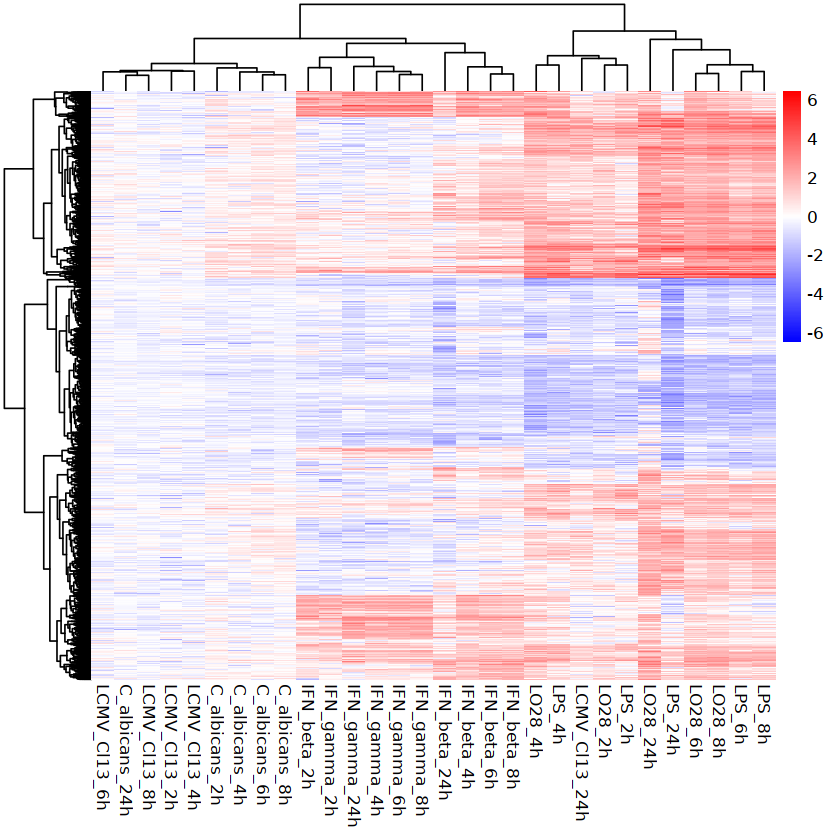

In [51]:
# clustered Heatmap of changes by LFC of significant genes (adj. p value <0.05, abs(LFC)>2, Average expression >1)
# logfcMT <- toMT(dt=res[grepl("_2h$", group)], row="rn", col="group", val="logFC")[unique(res.sig$rn),]

# filter sign. regions by average expression > 0
AveExprMT <- toMT(dt=res, row="rn", col="group", val="AveExpr")[unique(res.sig$rn),]
# make LFC matrix
logfcMT <- toMT(dt=res, row="rn", col="group", val="logFC")[rownames(AveExprMT[apply(AveExprMT, 1, max) > 0,]),]
# # filter LFC matrix for regions that at least once have abs(LFC) > 2
logfcMT2 <- logfcMT[apply(abs(logfcMT), 1, max) > 2,] 

# save filtered LFC table
write.table(logfcMT2, file.path(results_path, paste0('DEA_LFC_region_matrix.csv')) ,sep=",", row.names=TRUE, quote=FALSE)

# dd <- as.dist(1-minMax(cor(t(logfcMT2))))
px <- pheatmap(
  logfcMT2, show_rownames=F,
  #clustering_distance_rows=dd,
  breaks=seq(-max(abs(logfcMT)), max(abs(logfcMT)), length.out=200), 
  color=colorRampPalette(c("blue", "white", "red"))(200))

# cl.n <- 10 
for(cl.n in 4:12){
#   clusters <- melt(cutree(px$tree_row, cl.n))  ###### QUICK FIX
  clusters <- data.frame(value=cutree(px$tree_row, cl.n)) ###### QUICK FIX
  clusters$value <- factor(clusters$value)

  outCl <- file.path(results_path,paste0("Clusters_HM_", cl.n))
  dir.create(outCl)
    
  cleanDev(); pdf(file.path(outCl, paste0("Clusters_HM_", cl.n, ".pdf")),w=8,h=8)
  px <- pheatmap(logfcMT2, show_rownames=F, annotation_row=clusters, 
                 #clustering_distance_rows=dd, 
                 annotation_colors=list(value=setNames(RColorBrewer::brewer.pal(n=cl.n, name="Paired"), nm=unique(clusters$value))),               
                 breaks=seq(-max(abs(logfcMT)), max(abs(logfcMT)), length.out=200), 
                 color=colorRampPalette(c("blue", "white", "red"))(200))
  dev.off()
  

  regions <- data.table(clusters, keep.rownames=T)
#   genes <- merge(data.table(clusters, keep.rownames=T), RNA.gmap, by.x="rn", by.y="rn")
  write.tsv(regions, file.path(outCl, "Regions.tsv"))
  
#   enr <- enrichGeneList.oddsRatio.list(geneLists=with(genes, split(external_gene_name, value)), enrichrDBs=c("BioPlanet_2019", "KEGG_2019_Mouse", "NCI-Nature_2016", "WikiPathways_2019_Mouse", "Panther_2016", "BioCarta_2016", "GO_Biological_Process_2021"))
#   enrichr.plot.many(enr, out=file.path(paste0(outCl,"/")))                    
}


C_albicans_2h down   C_albicans_2h up C_albicans_4h down   C_albicans_4h up 
               448               2005                280               1058 
C_albicans_6h down   C_albicans_6h up C_albicans_8h down   C_albicans_8h up 
               262               1425               1540               3990 
 IFN_beta_24h down    IFN_beta_24h up   IFN_beta_2h down     IFN_beta_2h up 
             33484              21436               7300              11780 
  IFN_beta_4h down     IFN_beta_4h up   IFN_beta_6h down     IFN_beta_6h up 
              8848              15092              11268              19798 
  IFN_beta_8h down     IFN_beta_8h up IFN_gamma_24h down   IFN_gamma_24h up 
             22119              30595              25152              16829 
 IFN_gamma_2h down    IFN_gamma_2h up  IFN_gamma_4h down    IFN_gamma_4h up 
              8044              11628               8132              13234 
 IFN_gamma_6h down    IFN_gamma_6h up  IFN_gamma_8h down    IFN_gamma_8h up 
              6963              13022              20856              18780 
LCMV_Cl13_24h down   LCMV_Cl13_24h up  LCMV_Cl13_8h down      LO28_24h down 
             24025              21920                  1              16983 
       LO28_24h up       LO28_2h down         LO28_2h up       LO28_4h down 
             51098               8682              15778              16914 
        LO28_4h up       LO28_6h down         LO28_6h up       LO28_8h down 
             23368              17506              31364              37065 
        LO28_8h up       LPS_24h down         LPS_24h up        LPS_2h down 
             41185              42498              34693              12820 
         LPS_2h up        LPS_4h down          LPS_4h up        LPS_6h down 
             17394              15304              22547              17764 
         LPS_6h up        LPS_8h down          LPS_8h up 
             26556              36694              38608

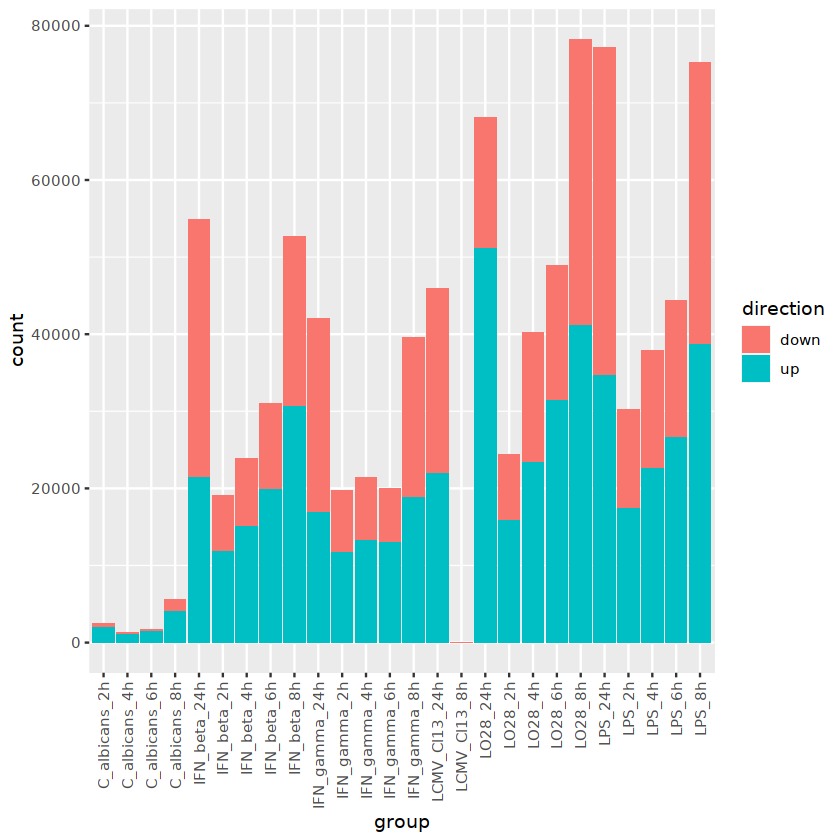

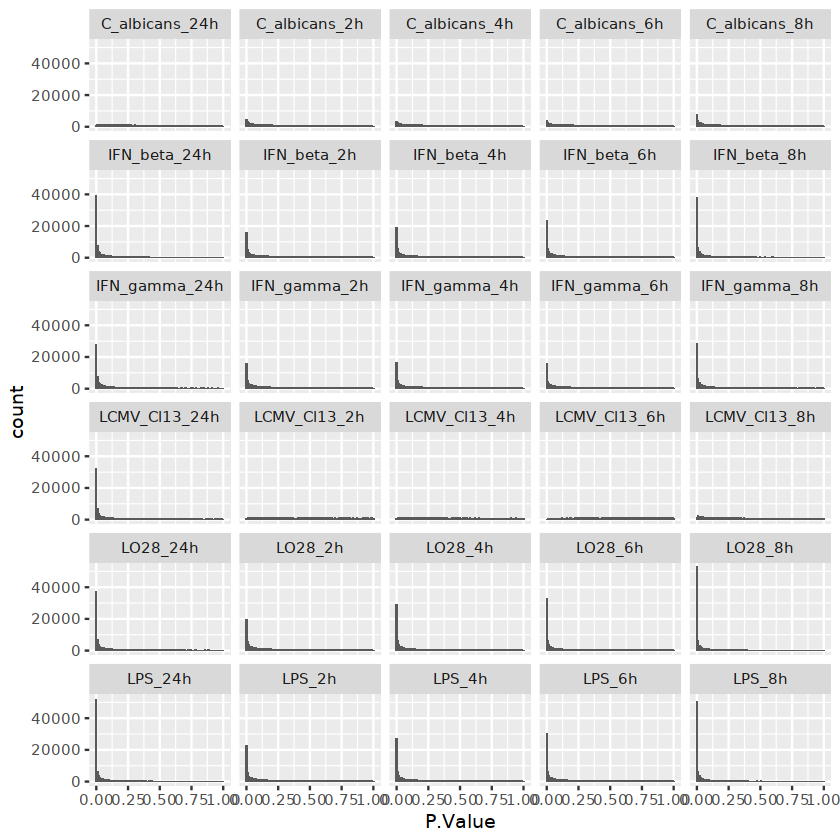

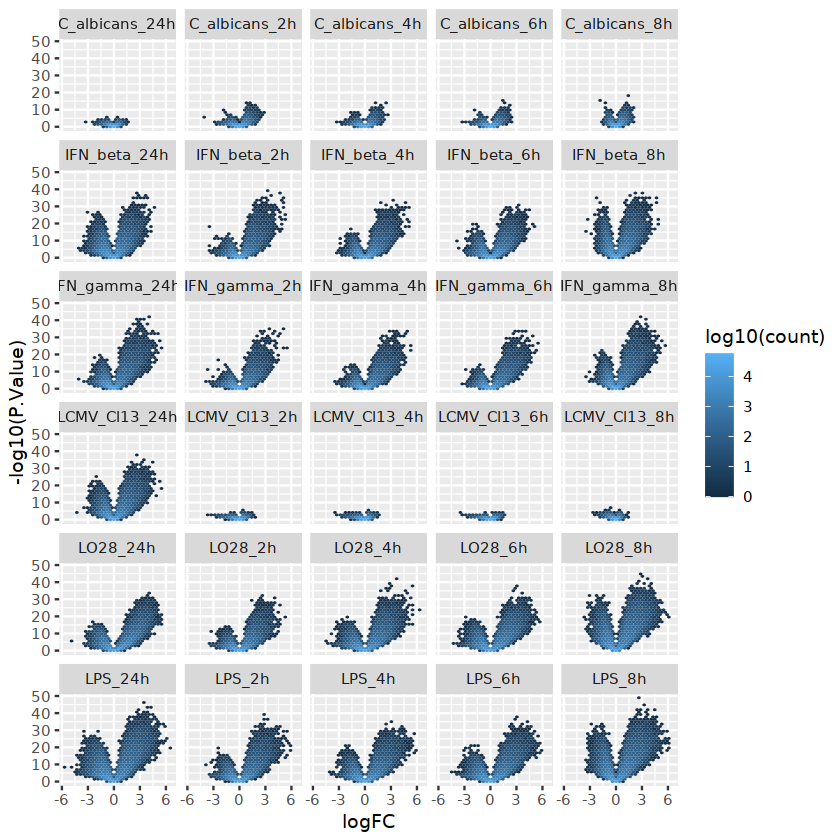

In [53]:
# Significant hits and Enrichment -----------------------------------------

# plot number of significant hits
ggplot(res.sig, aes(x=group, fill=direction)) + geom_bar() + xRot()
ggsave(file.path(results_path,  "NumberOfHits.pdf"), w=10,h=5)

res.sig.genes.list <- lapply(with(res.sig, split(rn, paste(group, direction))), unique)
sapply(res.sig.genes.list, length)

# pvalue dist
ggplot(res[AveExpr > 0], aes(x=P.Value)) + geom_histogram(bins=100) + facet_wrap(~group, ncol=5)
ggsave(file.path(results_path,  "PvalueDistribution.pdf"), w=8,h=8)

# volcano plots
ggplot(res[AveExpr > 0], aes(x=logFC, y=-log10(P.Value))) + stat_binhex(aes(fill=log10(..count..))) + facet_wrap(~group, ncol=5)
ggsave(file.path(results_path,  "VolcanoPlots.pdf"), w=8,h=8)

# Enrichr -> skip here, enrichment done with background and on region basis later
# enr <- enrichGeneList.oddsRatio.list(
#   geneLists=res.sig.genes.list,
#   enrichrDBs=c("BioPlanet_2019", "KEGG_2019_Mouse", "NCI-Nature_2016", "WikiPathways_2019_Mouse", "Panther_2016", "BioCarta_2016", "GO_Biological_Process_2021"))
# enrichr.plot.many(enrichRes=enr, out=file.path(paste0(results_path,"/")), label="Enrichr_")